In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys


def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


this_dir = osp.dirname('../../train.py')

lib_path = osp.join(this_dir, 'lib')
add_path(lib_path)

In [2]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from models.models import AE, SCSAE, HAE_V2

In [3]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
import tqdm
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [4]:
dred_down_train = '../../dataset/interim/dred_model_train.pt'
dred_down_test = '../../dataset/interim/dred_model_test.pt'

In [5]:
scsae_params = "../../model_param/state_4128850.pt"
hae2_params = "../../model_param/state_7437386.pt"
ae_params = "../../model_param/state_8894118.pt"

In [6]:
train_x, train_y = torch.load(dred_down_train)
test_x, test_y = torch.load(dred_down_test)

In [7]:
scsae_ = SCSAE(latent_n = 300, input_days = 60, wide_freq = 60, reshape_factor = 1)
hae_ = HAE_V2(latent_n = 300, input_days = 60, wide_freq = 60, reshape_factor = 1, device = 'cpu')
ae_ = AE(latent_n = 300, input_days = 60, wide_freq = 60)

scsae_.load_state_dict(torch.load(scsae_params)['state_dict'])
hae_.load_state_dict(torch.load(hae2_params)['state_dict'])
ae_.load_state_dict(torch.load(ae_params)['state_dict'])

scsae_.eval()
hae_.eval()
ae_.eval()

AE(
  (encoder): AE_Encoder(
    (fc1): Linear(in_features=3600, out_features=96, bias=True)
    (fc2): Linear(in_features=96, out_features=48, bias=True)
    (fc3): Linear(in_features=48, out_features=24, bias=True)
    (fc4): Linear(in_features=24, out_features=300, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AE_Decoder(
    (fc5): Linear(in_features=300, out_features=24, bias=True)
    (fc6): Linear(in_features=24, out_features=48, bias=True)
    (fc7): Linear(in_features=48, out_features=96, bias=True)
    (fc8): Linear(in_features=96, out_features=3600, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (sigmoid): Sigmoid()
  )
)

### Encode the Features

In [8]:
train_dataloader = DataLoader(train_x, batch_size = 512)
test_dataloader = DataLoader(test_x, batch_size = 512)

In [9]:
train_encoded = torch.zeros(1, 300)

for feat in train_dataloader:
    feat = feat.unsqueeze(1)
    out = scsae_.encoder(feat.float())
    train_encoded = torch.cat([train_encoded, out])
    
train_encoded = train_encoded[1:] # remove initial zeroes

test_encoded = torch.zeros(1, 300)

for feat in test_dataloader:
    feat = feat.unsqueeze(1)
    out = scsae_.encoder(feat.float())
    test_encoded = torch.cat([test_encoded, out])
    
test_encoded = test_encoded[1:] # remove initial zeroes

scsae_train_encoded = train_encoded.detach()
scsae_test_encoded = test_encoded.detach()

In [10]:
train_encoded = torch.zeros(1, 300)

for feat in train_dataloader:
    feat = feat.unsqueeze(1)
    out = hae_.encoder(feat.float())
    train_encoded = torch.cat([train_encoded, out])
    
train_encoded = train_encoded[1:] # remove initial zeroes

test_encoded = torch.zeros(1, 300)

for feat in test_dataloader:
    feat = feat.unsqueeze(1)
    out = hae_.encoder(feat.float())
    test_encoded = torch.cat([test_encoded, out])
    
test_encoded = test_encoded[1:] # remove initial zeroes

hae_train_encoded = train_encoded.detach()
hae_test_encoded = test_encoded.detach()

In [11]:
feat.shape

torch.Size([450, 1, 60, 60])

In [12]:
train_encoded = torch.zeros(1, 300)

for feat in train_dataloader:
    feat = feat.reshape(-1, 60*60)
    out = ae_.encoder(feat.float())
    train_encoded = torch.cat([train_encoded, out])
    
train_encoded = train_encoded[1:] # remove initial zeroes

test_encoded = torch.zeros(1, 300)

for feat in test_dataloader:
    feat = feat.reshape(-1, 60*60)
    out = ae_.encoder(feat.float())
    test_encoded = torch.cat([test_encoded, out])
    
test_encoded = test_encoded[1:] # remove initial zeroes

ae_train_encoded = train_encoded.detach()
ae_test_encoded = test_encoded.detach()

In [13]:
class EncodedDRED(Dataset):
    def __init__(self, train=True, encoder='ae'):
        if encoder == 'ae':
            if train is True:
                self.data = ae_train_encoded
                self.target = train_y
            else:
                self.data = ae_test_encoded
                self.target = test_y
        elif encoder == 'scsae':
            if train is True:
                self.data = scsae_train_encoded
                self.target = train_y
            else:
                self.data = scsae_test_encoded
                self.target = test_y
        elif encoder == 'hae':
            if train is True:
                self.data = hae_train_encoded
                self.target = train_y
            else:
                self.data = hae_test_encoded
                self.target = test_y
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

### Basic NN

In [14]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(nn.Linear(300, 128), nn.ReLU(), nn.Dropout(p=0.1),
#                                    nn.Linear(128, 32), nn.ReLU(), nn.Dropout(p=0.1), 
#                                    nn.Linear(32, 1),
#                                    nn.Sigmoid())

#     def forward(self, x):
#         x = self.model(x)
#         return x

In [15]:
# def build_and_get_model(dset, debug = False):
    
#     net = Net()

#     encoded_dset_train = EncodedDRED(train=True, encoder = dset)
#     encoded_dset_test = EncodedDRED(train=False, encoder=dset)
#     encoded_dloader_train = DataLoader(encoded_dset_train, batch_size = 32)
#     encoded_dloader_test = DataLoader(encoded_dset_test, batch_size = 32)

#     criterion = nn.BCELoss()
#     optimizer = optim.AdamW(net.parameters(), 1e-4, weight_decay = 1e-7)

#     for epoch in range(50):

#         net.train()
#         epoch_train_loss_avg = 0

#         for inputs, labels in (encoded_dloader_train):

#             labels = labels.unsqueeze(1).float()

#             out = net(inputs)
#             loss = criterion(out, labels)

#             with torch.no_grad():
#                 epoch_train_loss_avg += loss.item()

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         epoch_train_loss_avg /= len(encoded_dloader_train)

#         ### VALIDATE

#         net.eval()
#         epoch_val_loss_avg = 0
#         epoch_acc = 0

#         for inputs, labels in (encoded_dloader_test):

#             labels = labels.unsqueeze(1).float()
#             out = net(inputs)
#             loss = criterion(out, labels)

#             with torch.no_grad():
#                 epoch_val_loss_avg += loss.item()

#         epoch_val_loss_avg /= len(encoded_dloader_test)

#         if debug: print(f'Epoch: {epoch + 1} | Train Loss: {epoch_train_loss_avg: .3f} | Val Loss: {epoch_val_loss_avg: .3f}')
        
#     return net

In [16]:
# results = {'ae': {'accuracy': [], 'precision': [], 'recall': []},
#            'scsae':  {'accuracy': [], 'precision': [], 'recall': []},
#            'hae':  {'accuracy': [], 'precision': [], 'recall': []}}

# for i in range(10):

#     for dset_name in ['ae', 'scsae', 'hae']:

#         model = build_and_get_model(dset_name, False)

#         model.eval()
#         encoded_dset_test = EncodedDRED(train=False, encoder=dset_name)
#         encoded_dloader_test = DataLoader(encoded_dset_test, batch_size = 500)

#         for inputs, labels in encoded_dloader_test:

#             out = model(inputs)
#             out = out.reshape(-1).detach().numpy()
#             labels = labels.numpy()

#             thresh = 0.5
#             pred = np.where(out > thresh, 1, 0)

#             results[dset_name]['accuracy'].append(metrics.accuracy_score(labels, pred))
#             results[dset_name]['precision'].append(metrics.precision_score(labels, pred))
#             results[dset_name]['recall'].append(metrics.recall_score(labels, pred))

# df_results_nn = pd.DataFrame(results).apply(pd.Series.explode).reset_index()

In [17]:
# df_results_nn = pd.DataFrame.from_dict(results, orient = 'index').apply(pd.Series.explode).reset_index()

In [18]:
# df_results_nn.groupby('index').mean()

### Basic Classifier (Random Forest)

In [35]:
MODEL = "RandomForestClassifier()"

In [36]:
scsae_metrics = {'accuracy': [], 'precision': [], 'recall': []}

for i in tqdm.tqdm(range(25)):
    
    
    model = eval(MODEL)
    model.fit(scsae_train_encoded.numpy(), train_y.numpy())
    predictions = model.predict(scsae_test_encoded.numpy())
    # score = metrics.classification_report(test_y.numpy(), predictions)
    # print("SCSAE\n")
    # print(score)
    scsae_metrics['accuracy'].append(metrics.accuracy_score(test_y.numpy(), predictions))
    scsae_metrics['precision'].append(metrics.precision_score(test_y.numpy(), predictions))
    scsae_metrics['recall'].append(metrics.recall_score(test_y.numpy(), predictions))

 92%|█████████▏| 23/25 [00:26<00:02,  1.13s/it]

In [ ]:
hae_metrics = {'accuracy': [], 'precision': [], 'recall': []}

for i in tqdm.tqdm(range(25)):
    
    model = eval(MODEL)
    model.fit(hae_train_encoded.numpy(), train_y.numpy())
    predictions = model.predict(hae_test_encoded.numpy())
    # score = metrics.classification_report(test_y.numpy(), predictions)
    # print("SCSAE\n")
    # print(score)
    hae_metrics['accuracy'].append(metrics.accuracy_score(test_y.numpy(), predictions))
    hae_metrics['precision'].append(metrics.precision_score(test_y.numpy(), predictions))
    hae_metrics['recall'].append(metrics.recall_score(test_y.numpy(), predictions))

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


In [ ]:
ae_metrics = {'accuracy': [], 'precision': [], 'recall': []}

for i in tqdm.tqdm(range(25)):
    
    model = eval(MODEL)
    model.fit(ae_train_encoded.numpy(), train_y.numpy())
    predictions = model.predict(ae_test_encoded.numpy())
    # score = metrics.classification_report(test_y.numpy(), predictions)
    # print("SCSAE\n")
    # print(score)
    ae_metrics['accuracy'].append(metrics.accuracy_score(test_y.numpy(), predictions))
    ae_metrics['precision'].append(metrics.precision_score(test_y.numpy(), predictions))
    ae_metrics['recall'].append(metrics.recall_score(test_y.numpy(), predictions))

100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


### Metrics

In [ ]:
df_scsae = pd.DataFrame(scsae_metrics)
df_scsae['model'] = 'scsae'
df_hae = pd.DataFrame(hae_metrics)
df_hae['model'] = 'hae'
df_ae = pd.DataFrame(ae_metrics)
df_ae['model'] = 'ae'
df_both = pd.concat([df_hae, df_scsae, df_ae])

In [ ]:
df_both.groupby('model').mean()

,accuracy,precision,recall
model,,,
ae,0.854978,0.233727,0.292564
hae,0.864622,0.242673,0.261795
scsae,0.884933,0.357064,0.406667


In [ ]:
df_both.groupby('model').var()

,accuracy,precision,recall
model,,,
ae,0.000098,0.000954,0.001104
hae,0.000087,0.001064,0.001040
scsae,0.000051,0.001003,0.001873


<AxesSubplot:xlabel='model', ylabel='accuracy'>

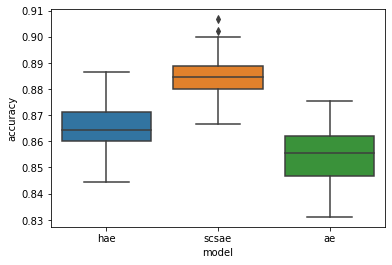

In [ ]:
sns.boxplot(data = df_both, x = 'model', y='accuracy')

<AxesSubplot:xlabel='model', ylabel='precision'>

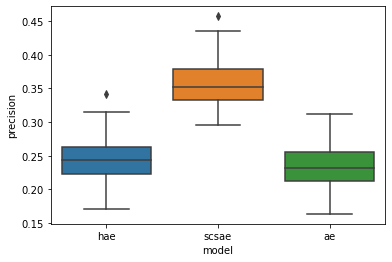

In [29]:
sns.boxplot(data = df_both, x = 'model', y='precision')

<AxesSubplot:xlabel='model', ylabel='recall'>

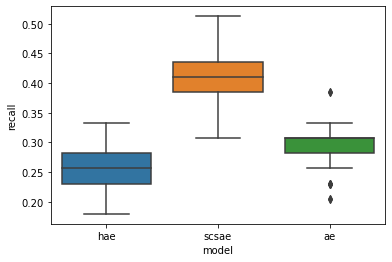

In [30]:
sns.boxplot(data = df_both, x = 'model', y='recall')